# Explorating Pace, and Shot Distribution in Basketball

In recent years, there has been a notable surge in scoring proficiency and overall efficiency within the NBA, marked by a significant increase in pace of play. This trend has led to a greater frequency of high-scoring games, redefining the landscape of professional basketball. However, it remains an open question as to whether similar patterns are evident in the Euroleague, the premier basketball competition in Europe, and if so, how these trends may differ from those observed in the NBA.

To address this question, we propose an exploratory data analysis (EDA) to examine various statistical metrics and trends within the Euroleague dataset. By analyzing factors such as points scored per game, shooting percentages, and pace of play, we aim to gain insights into the evolving dynamics of European basketball and compare them to the trends observed in the NBA.

Through this analysis, we seek to elucidate any similarities or divergences between the two leagues, shedding light on the broader trends shaping the modern game of basketball on a global scale. Such insights not only contribute to our understanding of the sport but also have implications for strategic decision-making within the basketball industry, from team management to player development and beyond.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# euroleague is an interesting library that uses the API of euroleague to scrap data since 2001, 
# when the competition was named as euroleague.
from euroleague_api import team_stats
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import TeamYearByYearStats

# Data NBA

In [149]:
# Get the different teams in the league
nba_teams = teams.get_teams()

In [150]:
# USing the id in team['id'] we select the stats of each team.
data_nba = pd.DataFrame()
for team in nba_teams:
    data = TeamYearByYearStats(team_id = team['id'], per_mode_simple = 'PerGame')
    data = data.get_data_frames()
    data = pd.DataFrame(data[0])
    data_nba = pd.concat([data_nba, data])

In [151]:
# The year comes with 2000 - 01. Thus to have comparable data to the Euroleague we removed the text keeping just the start
# that correspond with the start year of the season. 
def process_year(year):
    return year.rsplit('-', 1)[0]
data_nba['YEAR'] = data_nba['YEAR'].apply(process_year)

In [152]:
# We keep only the data of the years that are over 2000. We do this cause this is the data we have available in the Euroleague.
data_nba['YEAR'] = pd.to_numeric(data_nba['YEAR'])
data_nba = data_nba[data_nba['YEAR'] >= 2002]

In [153]:
# Calculate 2 pointer field goal made, attempted and the PCT. 
data_nba['FG2M']= data_nba['FGM']-data_nba['FG3M']
data_nba['FG2A']= data_nba['FGA']-data_nba['FG3A']
data_nba['FG2_PCT']= data_nba['FG2M']/data_nba['FG2A']

In [154]:
# Calculate total possesions in each game. The offensive rating (points per 100 offensive possesions), and PTS per minutes 
data_nba['Possesions']=2*(0.96*((data_nba['FGA'])+(data_nba['TOV'])
                            +0.44*(data_nba['FTA'])
                            -(data_nba['OREB'])))
data_nba['Offensive_rating'] = (data_nba['PTS']/(data_nba['Possesions']/2))*100
data_nba['PTS_Min'] = data_nba['PTS']/48

# Data from the Euroleague

In [142]:
# The documentation has 2 types of data (traditional and advanced) that can be extracted for attack
# and defense(opponents preceding the type of data in the function). We will be extracting the data
# for all seasons that are available.
endpoints = ['traditional', 'opponentsTraditional', 'advanced', 'opponentsAdvanced']
data_euroleague=pd.DataFrame()
for i in range(2002, 2024):
    endpoint_data = pd.DataFrame()
    for j in endpoints:
        if endpoint_data.empty:
            endpoint_data =  team_stats.get_team_stats_single_season(endpoint=j, season=i, phase_type_code='RS', statistic_mode='PerGame')
        else: 
            endpoint_data = pd.merge(endpoint_data,  team_stats.get_team_stats_single_season(endpoint=j, season=i, phase_type_code='RS', statistic_mode='PerGame'), on='team.code', suffixes=('', f'_{j}'))

    endpoint_data['Season'] = i
    data_euroleague = pd.concat([data_euroleague, endpoint_data])
    
data_euroleague.reset_index(drop=True, inplace=True)


In [143]:
# We will now drop the 
columns_to_drop = [
    'teamRanking', 'gamesPlayed', 'team.tvCodes', 'team.imageUrl',
    'teamRanking_opponentsTraditional', 'gamesPlayed_opponentsTraditional',
    'minutesPlayed_opponentsTraditional', 'team.tvCodes_opponentsTraditional', 
    'team.name_opponentsTraditional', 'team.imageUrl_opponentsTraditional',
    'teamRanking_advanced', 'gamesPlayed_advanced', 'team.tvCodes_advanced',
    'team.name_advanced', 'team.imageUrl_advanced', 'teamRanking_opponentsAdvanced',
    'gamesPlayed_opponentsAdvanced', 'team.tvCodes_opponentsAdvanced', 
    'team.name_opponentsAdvanced', 'team.imageUrl_opponentsAdvanced', 
    'blocks_opponentsTraditional','blocksAgainst_opponentsTraditional',
    'foulsCommited_opponentsTraditional', 'foulsDrawn_opponentsTraditional'   
]

# Drop columns
data_euroleague.drop(columns_to_drop, inplace=True, axis='columns')

In [144]:
data_euroleague.head()

,minutesPlayed,pointsScored,twoPointersMade,twoPointersAttempted,twoPointersPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,...,assistsToTurnoversRatio_opponentsAdvanced,assistsRatio_opponentsAdvanced,turnoversRatio_opponentsAdvanced,twoPointRate_opponentsAdvanced,threePointRate_opponentsAdvanced,freeThrowsRate_opponentsAdvanced,pointsFromTwoPointersPercentage_opponentsAdvanced,pointsFromThreePointersPercentage_opponentsAdvanced,pointsFromFreeThrowsPercentage_opponentsAdvanced,Season
0,40.357143,71.4,20.9,43.5,47.9%,4.6,15.2,30%,16.0,21.8,...,0.9,14%,14.7%,67.5%,32.5%,49.2%,49%,25.4%,25.6%,2002
1,40.357143,76.0,22.9,45.1,50.7%,4.6,14.7,31.6%,16.4,24.1,...,1.0,15%,14.3%,68.7%,31.3%,44.3%,51.9%,24.6%,23.5%,2002
2,40.000000,74.2,17.1,34.9,49.1%,7.4,18.4,40.5%,17.6,24.0,...,1.1,12.2%,11.3%,65.5%,34.5%,43%,48.4%,28.3%,23.4%,2002
3,40.000000,78.9,21.0,40.6,51.7%,7.7,22.4,34.5%,13.8,19.9,...,0.5,9.6%,17.6%,70.5%,29.5%,48%,52.5%,22%,25.6%,2002
4,40.357143,79.2,20.4,42.9,47.5%,4.9,15.1,32.5%,23.7,32.3,...,1.1,15%,13.7%,64.3%,35.7%,55.4%,42.8%,30.4%,26.8%,2002


In [145]:
# Loop through each column in object_variables, Check if the column is of type 'object',Exclude specific columns from the operation
# Apply the operation
object_variables = data_euroleague.columns.tolist()
for column in object_variables:
    if data_euroleague[column].dtype == 'object':
        if column not in ['team.code', 'team.name']:
            data_euroleague[column] = data_euroleague[column].apply(lambda x: float(x.strip('%')) / 100)

# Data procesing
Creating Possesions, and Offensive and Defensive Rating. For Nba we will create the possesions based on the attacking possesions and multiply by 2.

In [146]:
data_euroleague['Possesions']=0.96*((data_euroleague['twoPointersAttempted']+
                                    data_euroleague['threePointersAttempted']+
                                    data_euroleague['twoPointersAttempted_opponentsTraditional'] +
                                    data_euroleague['threePointersAttempted_opponentsTraditional'])+(data_euroleague['turnovers']+data_euroleague['turnovers_opponentsTraditional'])
                                   +0.44*(data_euroleague['freeThrowsAttempted']+data_euroleague['freeThrowsAttempted_opponentsTraditional'])-(data_euroleague['offensiveRebounds']+data_euroleague['offensiveRebounds_opponentsTraditional']))

In [147]:
data_euroleague['Offensive_Possesions']=0.96*((data_euroleague['twoPointersAttempted']+
                                    data_euroleague['threePointersAttempted'])+
                                    +(data_euroleague['turnovers'])
                                   +0.44*(data_euroleague['freeThrowsAttempted'])-(data_euroleague['offensiveRebounds']))

In [148]:
data_euroleague['Offensive_Rating'] = 100*(data_euroleague['pointsScored'] /  data_euroleague['Offensive_Possesions'] )   
data_euroleague['PTS_Min'] = data_euroleague['pointsScored']/40

# Graphs

## NBA

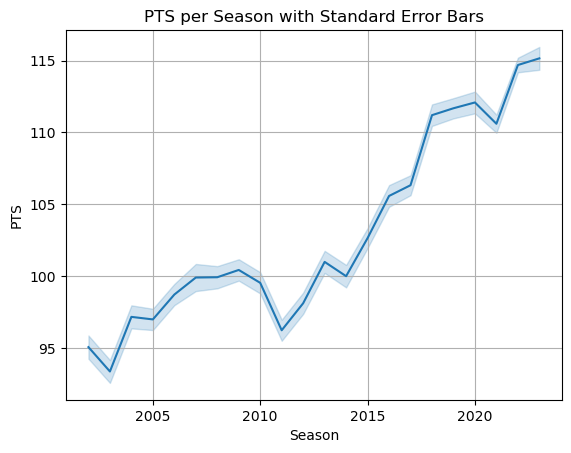

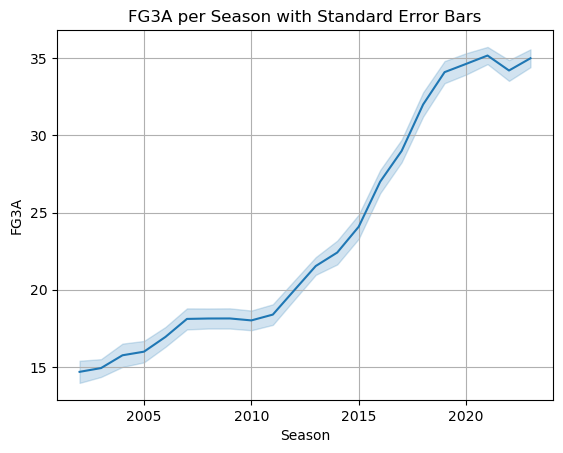

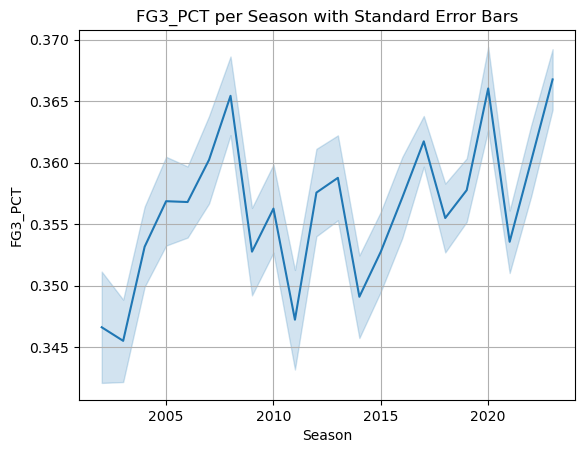

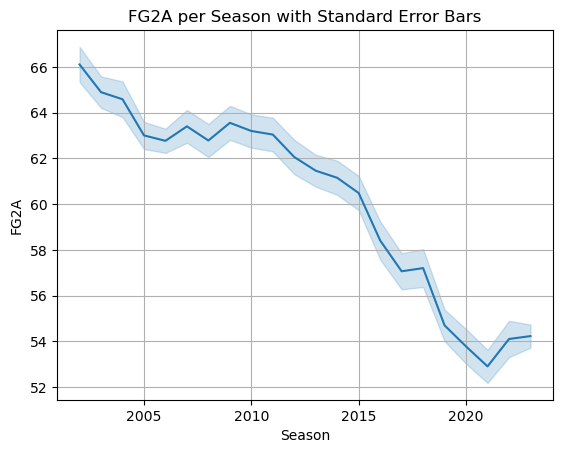

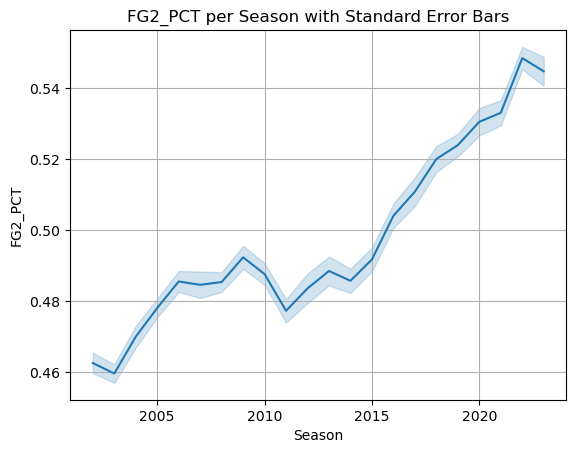

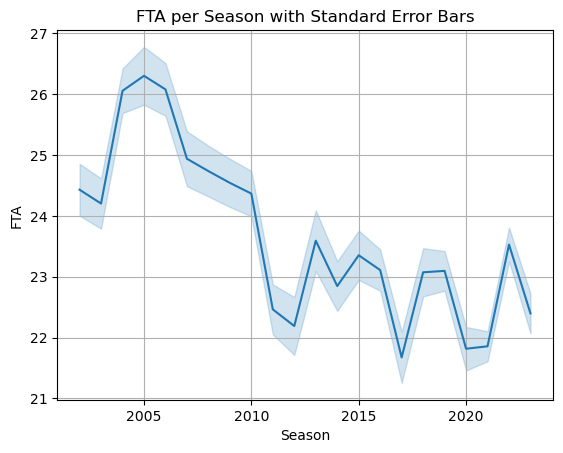

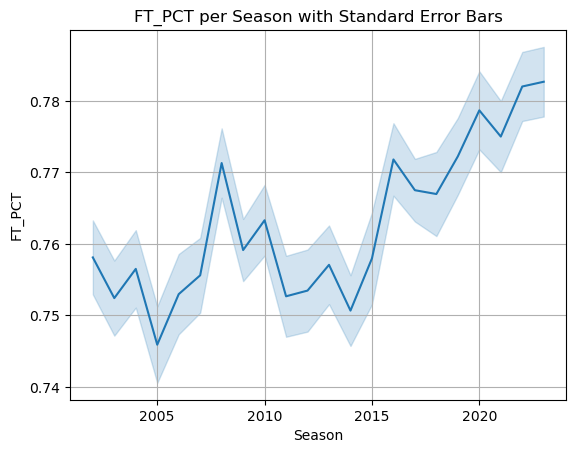

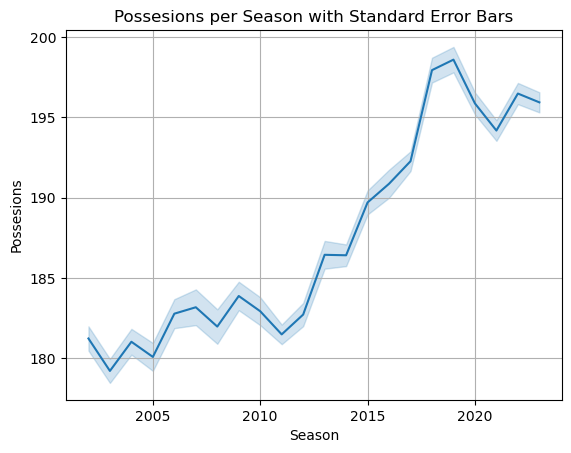

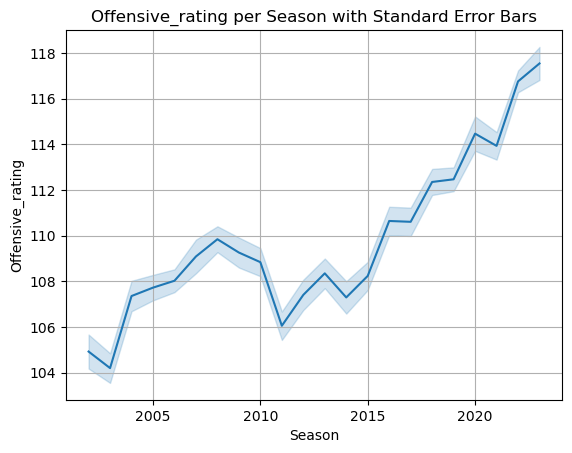

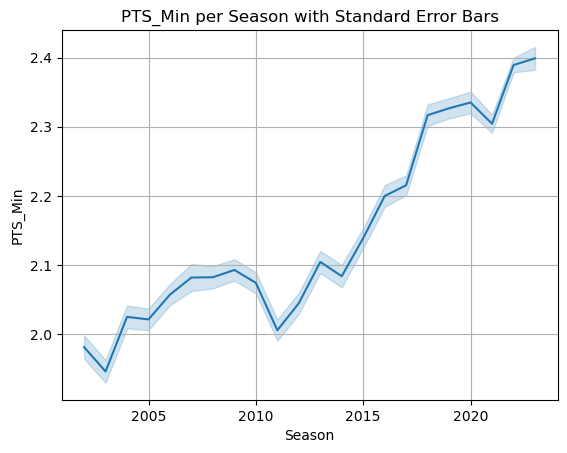

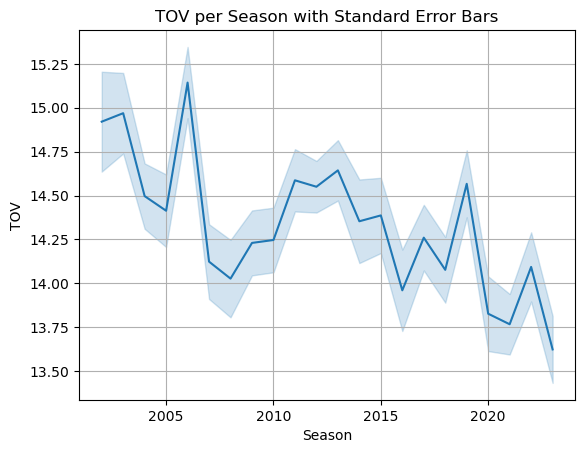

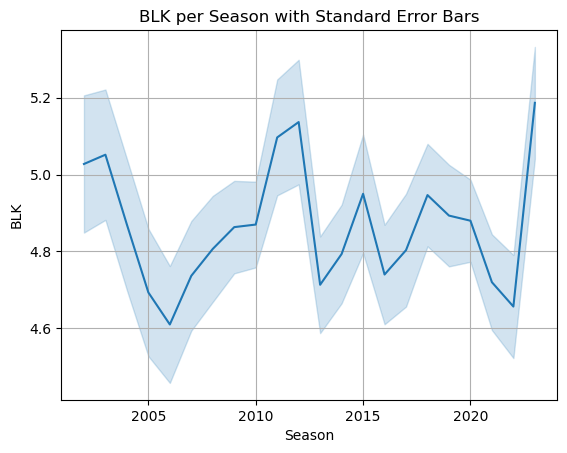

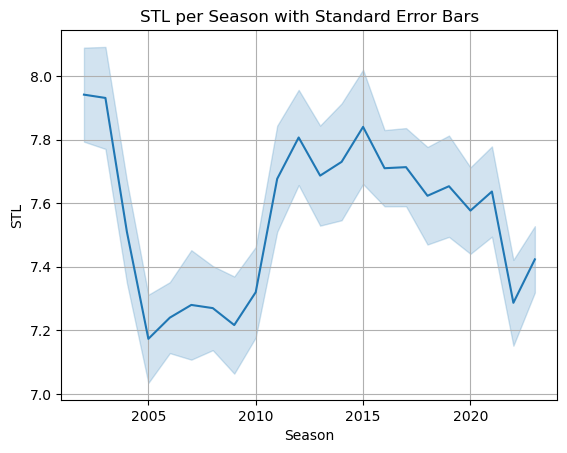

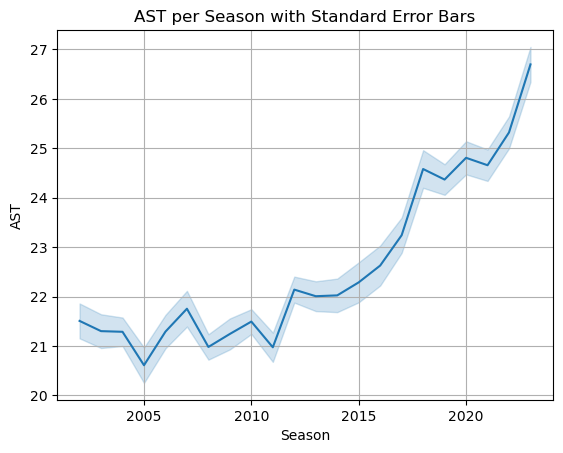

In [155]:
import seaborn as sns

for i in (['PTS','FG3A','FG3_PCT', 'FG2A', 'FG2_PCT','FTA','FT_PCT','Possesions','Offensive_rating','PTS_Min','TOV','BLK','STL','AST']):
    # Assuming df is your DataFrame with columns 'Season' and 'pointsScored'
    sns.lineplot(data=data_nba, x='YEAR', y=i,errorbar='se')
    plt.xlabel('Season')
    plt.ylabel(i)
    plt.title(i+' per Season with Standard Error Bars')
    plt.grid(True)  # Adding grid for better readability
    plt.show()

**Observations:** The number of 3 point field goal attempts (3FGA), offensive rating, and points per game have been steadily increasing. However, the pace of play has stabilized in recent years after experiencing constant growth for a prolonged period. Another noteworthy finding is that the number of two-pointers attempted has been decreasing over the years, while the percentage of successful two-point shots has been on the rise.

## Euroleague

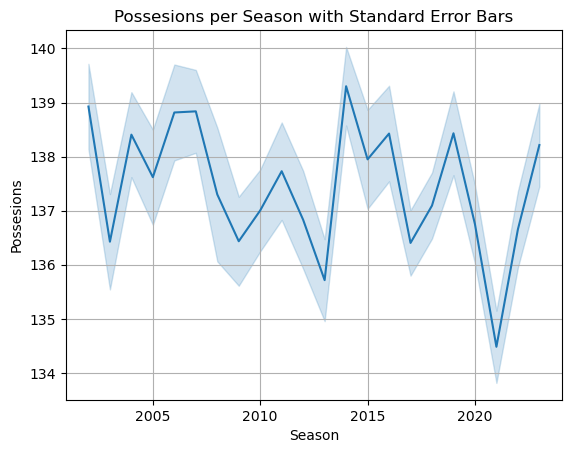

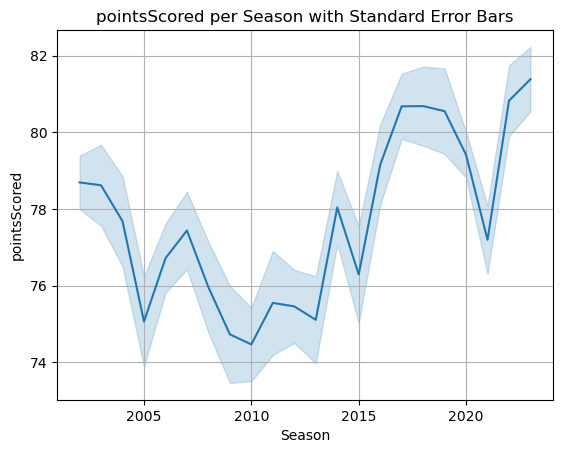

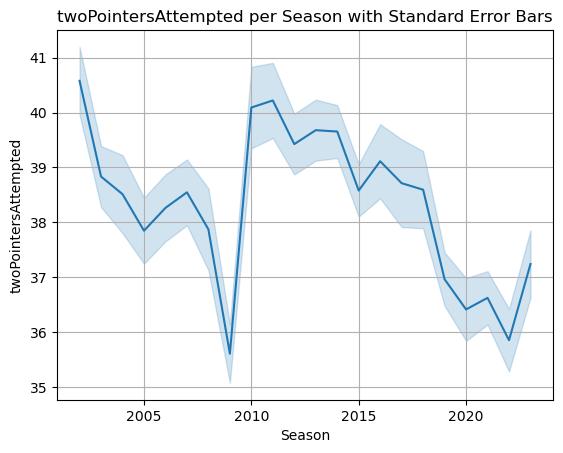

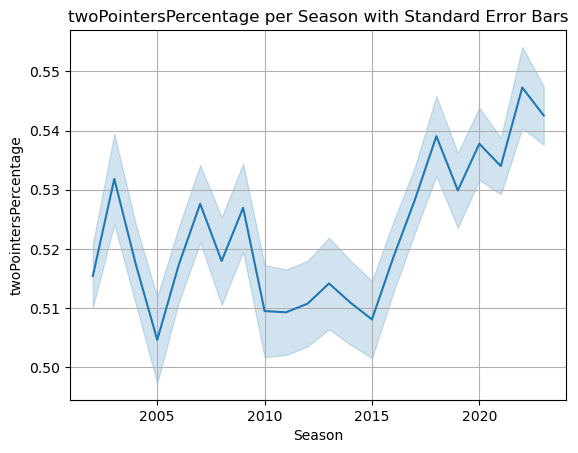

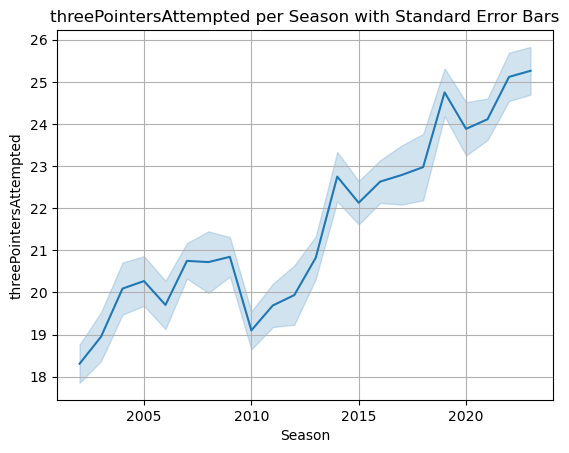

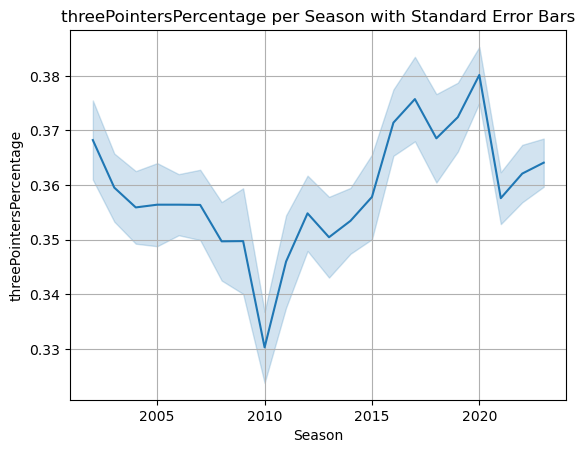

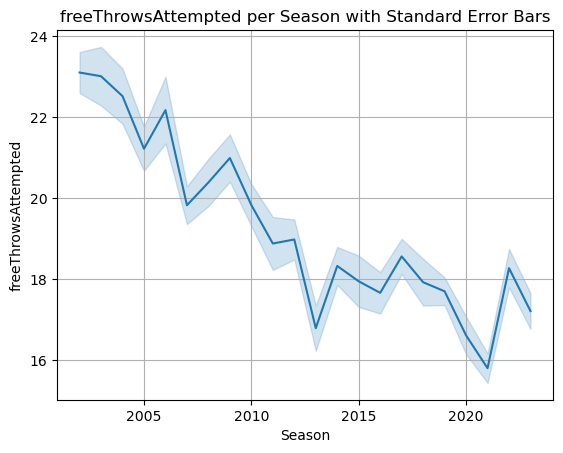

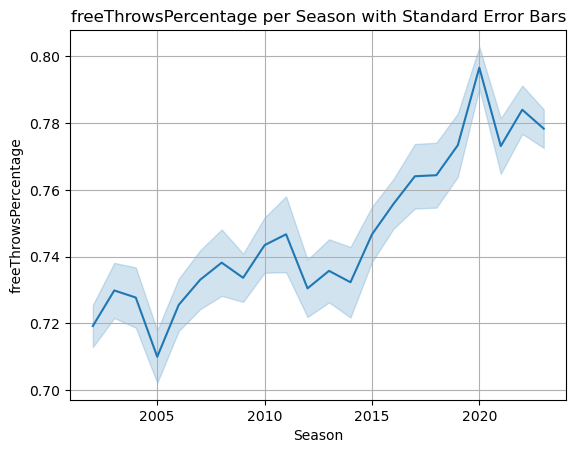

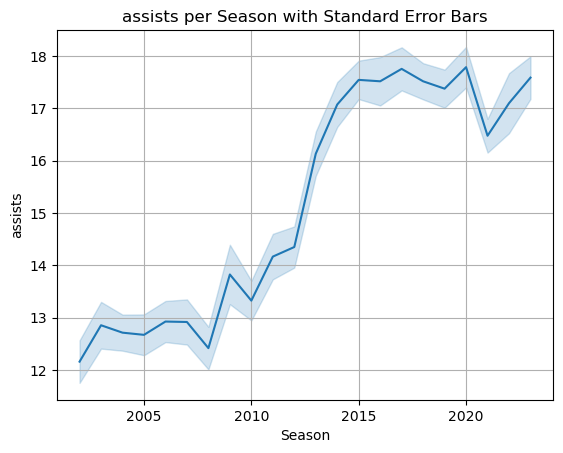

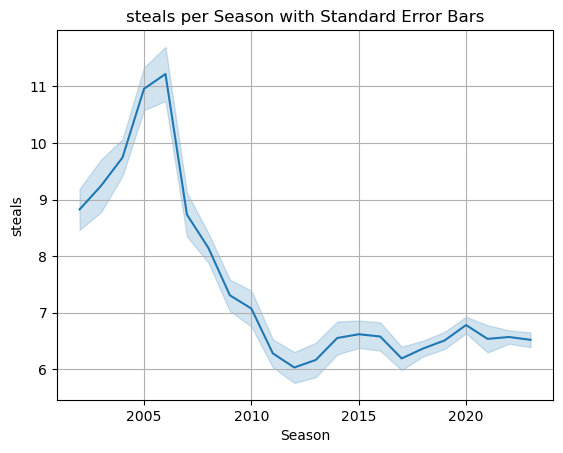

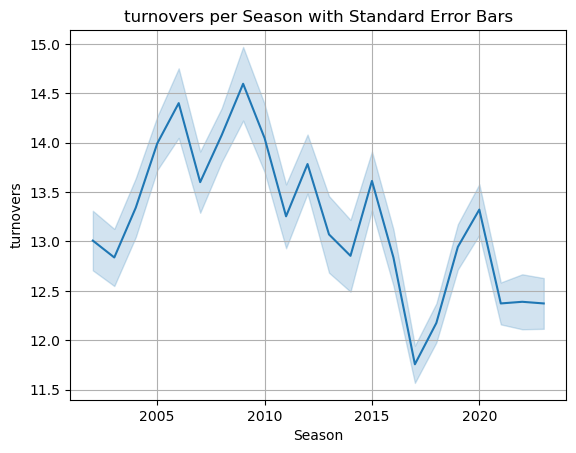

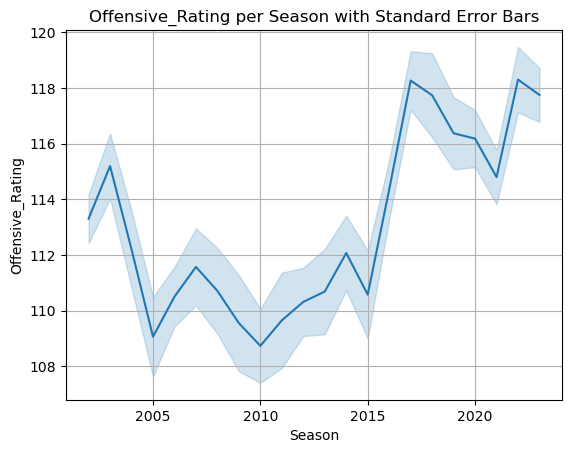

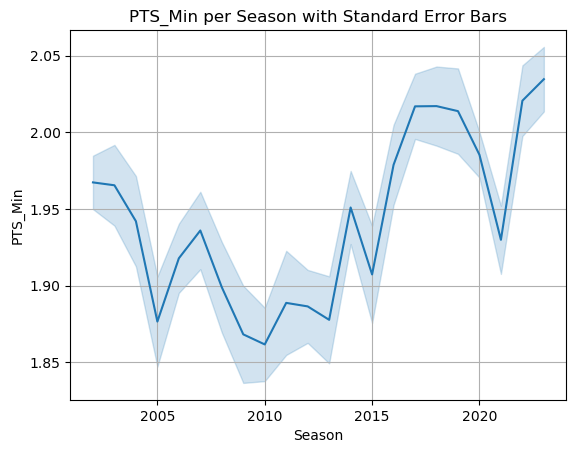

In [156]:
import seaborn as sns

for i in (['Possesions','pointsScored','twoPointersAttempted','twoPointersPercentage','threePointersAttempted', 
           'threePointersPercentage', 'freeThrowsAttempted','freeThrowsPercentage','assists','steals','turnovers', 
           'Offensive_Rating','PTS_Min']):
    # Assuming df is your DataFrame with columns 'Season' and 'pointsScored'
    sns.lineplot(data=data_euroleague, x='Season', y=i,errorbar='se')
    plt.xlabel('Season')
    plt.ylabel(i)
    plt.title(i+' per Season with Standard Error Bars')
    plt.grid(True)  # Adding grid for better readability
    plt.show()

**Observations:** The number of 3 point field goal attempts (3FGA), and offensive rating has grown in the last year. Contrary to popular beleive offensive rating is comparable to NBA. However, it doesnt seem as if possesions went up in the last year. This is consistent with the idea that Euroleague has longer possesions with less running. Also we don't see the steady increase in 2point Percentage shot, which means that Euroleague 2 pointers have been of less quality.